# Let's Train GLaM 





### Configure the machine and install packages


In [1]:
from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on darwin


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/Users/vikram/dev/jaxpt/src


In [3]:
import os
import warnings

import jax
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)
devices = jax.devices()
#num_devices = len(devices)
num_devices = 8
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

#jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.4
Available devices: 8


/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_73201/2251500124.py:23: UserWarning: not using gpu. Using cpu
  warnings.warn(f"not using {requested_device}. Using {device}")


219 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the Mobile-LLM model and perform a sanity check

In [4]:
from datetime import datetime
import random
import string

from jaxpt.checkpointers import save_checkpoint, load_checkpoint, load_checkpoint_from_gcloud

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "cuda":
  output_dir = Path("/home/ubuntu/alpha_training_runs") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent  / "alpha_training_runs" # Local setup

Run: run_20250608_szwhdu


In [ ]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import GLaM, GLaM_Config
from jaxpt.models.mobile_llm import from_hf_pretrained
from jaxpt.utils import count_params

from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = GLaM_Config(dtype=jnp.bfloat16, \
                     sdpa_implementation="cudnn" if device=="gpu" else "xla",)
nnx.display(config)

m = GLaM(config, rngs)
#m = load_checkpoint_from_gcloud(Mobile_LLM, config, output_dir, "alpha_training_runs", "run_20250521_pakugd", "9000", rngs)
#m = load_checkpoint(Mobile_LLM, output_dir, config, "run_20250521_pakugd", 9000, rngs)
#m = from_hf_pretrained(config, rngs)

graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
total_params = count_params(m)

print(f"Parameter Count: {total_params:,}")
nnx.display(state)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
completions = generate_completions(m, enc=tokenizer, num_completions=5,
                                   max_length=21,
                                   prefix="Ducks quack, donkeys bray, cats mew, horses")
for completion in completions:
    print(completion)

Parameter Count: 1,921,665,792


### Configure Training Run

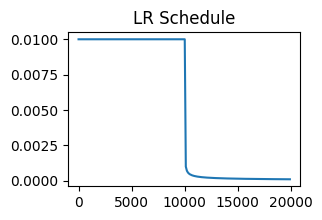

tokens/batch: 524,288
block size: 1024
sub-batch size: 64
no. gradient accumulation steps: 1
effective batch size per device:  64
effective batch size: 512
max steps: 20,000


In [31]:
import dataclasses
from functools import partial

import matplotlib.pyplot as plt

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**19
  mB: int = 64
  T: int = 1024
  max_steps: int = 20_000
  max_lr: float = 1e-2
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 10_000
  print_interval: int = 20
  eval_interval: int = 1000
  checkpoint_interval: int = 1000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)
trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

def inverse_sqrt_decay_schedule(warmup_steps, max_lr, step):
  return jnp.where(step+1 < warmup_steps, 
                    max_lr, 
                    max_lr * ((step+1-warmup_steps) ** (-0.5)))

lr_schedule = partial(inverse_sqrt_decay_schedule,
                      trconf.warmup_steps,
                      trconf.max_lr)

steps = range(0, trconf.max_steps, 100)
total_schedule = [ lr_schedule(step) for step in steps ]

plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)

tx = optax.chain(
    optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adafactor(lr_schedule, 
    decay_rate=0.8) 
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0


print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [34]:
trconf.T

1024

In [35]:
import os

from jaxpt.dataloaders import HuggingfaceDataLoader

train_dl = HuggingfaceDataLoader(batch_size=trconf.mB,
                                 block_size=trconf.T,
                                 device_rank=num_devices,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)



Initializing tokenizer HuggingFaceTB/SmolLM-135M


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/234 [00:00<?, ?it/s]

HuggingfaceDataLoader initialized:
------------------------
label:          train
shards:         0
shard size:     299
batch size:     64
block size:     1024
device rank:    8
------------------------


In [36]:
from jaxpt.utils import append_to_csv

# Create log dir
log_dir = output_dir / m.config.name / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
step = 0

Log directory: /Users/vikram/dev/jaxpt/alpha_training_runs/GLaM/logs


In [40]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.train import parallel_train_step

m.train()
try:
  while step < trconf.max_steps:
    start = time.time()
    batch, target = train_dl()
    avg_loss, avg_grads = parallel_train_step(m, optimizer, batch, target)
    avg_loss.block_until_ready()
    # compute stats
    avg_loss = jax.device_get(avg_loss)
    avg_loss = jnp.float32(avg_loss[0])
    lr = trapezoidal_schedule(step)
    iter_time = time.time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      train_losses.append((step, avg_loss))
      append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | "
            f"loss: {avg_loss:0.4f} | "
            f"time: {iter_time*1000:0.2f}ms | "
            f"tokens processed: {tokens_processed:,} | "
            f"tok/sec: {tokens_per_sec:,.2f}", end="\r")
    if step % trconf.eval_interval == 0:
      print("Evaluation TBD")
      save_checkpoint(m, run_dirname, step)
    step += 1

except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

plt.figure(figsize=(5, 3))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.legend()
plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


ValueError: too many values to unpack (expected 3)

In [ ]:
save_checkpoint(m, run_dirname, step)

In [7]:
import logging

from jaxpt.infer import generate_chat

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Prevent logs from being propagated to the root logger
logger.propagate = False
# Remove all existing handlers
logger.handlers.clear()
# Create a console handler
console_handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
if not logger.handlers:
    logger.addHandler(console_handler)

question = "What is the capital of the Indian state of Maharashtra?"

m.eval()
generate_chat(m, enc=tokenizer, format="chatml", question=question, logger=logger)

Model: Maharashtra

